# Q Learning MLP

In [1]:
import gym
import torch
import itertools

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from agents import QLearningAgent

from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from time import sleep

In [2]:
%load_ext tensorboard

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.act = activation_fn()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.act(self.fc1(x)) / 10
        x = self.fc2(x)
        return x

## Cart Pole

- Objective: keep a pendulum upright for as long as possible
- 2 actions: left (force = -1), right (force = +1)
- Reward: +1 for every timestep that the pole remains upright
- Game ends when pole more the 15° from vertical OR cart moves > 2.4 units from center

In [4]:
def init_weights(mlp: MLP):
    gamma = torch.tensor([5.0, 2.0, 1.0, 0.5])
    nn.init.normal_(mlp.fc1.weight, mean=0, std=1)
    mlp.fc1.weight.data = mlp.fc1.weight.data * gamma
    nn.init.uniform_(mlp.fc1.bias, a=0, b=np.pi * 2)

In [5]:
LEARNING_RATES = [1e-4, 0.1]
DISCOUNT_FACTORS = [0.99]
EXPLORATION_RATES = [0.0, 0.5]
ACTIVATION_FNS = [nn.Sigmoid, nn.Tanh]
EPISLON_DECAY = 0.99
NUM_EPISODES = 1_000
MAX_STEPS = 2_000
FPS = 30

In [6]:
env = gym.make("CartPole-v1")
writer = SummaryWriter()

pbar = tqdm(list(itertools.product(LEARNING_RATES, DISCOUNT_FACTORS, EXPLORATION_RATES, ACTIVATION_FNS)))
for (lr, df, er, af) in pbar:
    model = MLP(env.observation_space.shape[0], 400, env.action_space.n, activation_fn=af)
    init_weights(model)
    
    agent = QLearningAgent(env, model, learning_rate=lr, gamma=df, epsilon=er, 
                           epsilon_decay=EPISLON_DECAY, episodes=NUM_EPISODES, max_steps=MAX_STEPS)
    
    rewards = agent.train()
        
    for i, reward in enumerate(rewards):
        writer.add_scalar(f"Reward/alpha={lr}_gamma={df}_epsilon={er}_activation={af.__name__}", reward, i)


writer.close()

  0%|          | 0/8 [00:00<?, ?it/s]

In [7]:
%tensorboard --logdir=runs

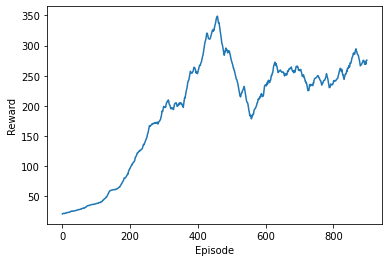

In [8]:
env = gym.make("CartPole-v1")

model = MLP(env.observation_space.shape[0], 400, env.action_space.n, activation_fn=nn.Sigmoid)
init_weights(model)

agent = QLearningAgent(env, model, learning_rate=0.1, gamma=0.99, epsilon=0.5, 
                       epsilon_decay=EPISLON_DECAY, episodes=NUM_EPISODES, max_steps=MAX_STEPS)

rewards = agent.train()

smoothed_rewards = []
smooth_window = 50
for i in range(smooth_window, len(rewards) - smooth_window):
    smoothed_rewards.append(np.mean(rewards[i-smooth_window:i+smooth_window]))

plt.plot(smoothed_rewards)
plt.xlabel(f"Episode")
plt.ylabel("Reward")
plt.show()

In [14]:
total_reward = 0

env = gym.make("CartPole-v1")

state = env.reset()
for step in range(MAX_STEPS):
    action = agent.act(state, train=False)
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    env.render()
    sleep(1 / FPS)
    state = next_state
    if done:
        break

env.close()

print(total_reward)

165.0
